In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import tensorflow.keras.callbacks
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data_shakespeare = open('/tmp/sonnets.txt').read()

--2020-09-05 14:26:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-09-05 14:26:39 (92.6 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
tokenizer_shakespeare = Tokenizer()

corpus_shakespeare  = data_shakespeare.lower().split("\n")

tokenizer_shakespeare.fit_on_texts(corpus_shakespeare)
total_words_shakespeare = len(tokenizer_shakespeare.word_index) + 1

# create input sequences using list of tokens
input_sequences_shakespeare = []
for line in corpus_shakespeare:
	token_list = tokenizer_shakespeare.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences_shakespeare.append(n_gram_sequence)


# pad sequences 
max_sequence_len_shakespeare = max([len(x) for x in input_sequences_shakespeare])
input_sequences_shakespeare = np.array(pad_sequences(input_sequences_shakespeare, maxlen=max_sequence_len_shakespeare, padding='pre'))

# create predictors and label
predictors_shakespeare, label_shakespeare = input_sequences_shakespeare[:,:-1],input_sequences_shakespeare[:,-1]

label_shakespeare = ku.to_categorical(label_shakespeare, num_classes=total_words_shakespeare)

In [4]:
print(max_sequence_len_shakespeare)

11


In [5]:
print(total_words_shakespeare)

3211


In [6]:
model_shakespeare = Sequential()
model_shakespeare.add(Embedding(total_words_shakespeare, 100, input_length=max_sequence_len_shakespeare-1))
model_shakespeare.add(Bidirectional(LSTM(150)))
#model_shakespeare.add(Dropout(0.2))
#model_shakespeare.add(LSTM(10))
#model_shakespeare.add(Dense(total_words_shakespeare/2, kernel_regularizer=L2(0.01), activation='relu'))
model_shakespeare.add(Dense(total_words_shakespeare, activation='softmax'))

optimizer = Adam(0.01)

model_shakespeare.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model_shakespeare.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 3211)              966511    
Total params: 1,588,811
Trainable params: 1,588,811
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
lr_schedule = tensorflow.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

In [8]:
history_shakespeare = model_shakespeare.fit(predictors_shakespeare, label_shakespeare, epochs=80, verbose=1, 
                                #callbacks=[lr_schedule]
                                )

Epoch 1/80
484/484 [==============================] - 5s 10ms/step - loss: 6.8028 - accuracy: 0.0297
Epoch 2/80
484/484 [==============================] - 4s 9ms/step - loss: 6.1209 - accuracy: 0.0581
Epoch 3/80
484/484 [==============================] - 5s 9ms/step - loss: 5.4343 - accuracy: 0.0837
Epoch 4/80
484/484 [==============================] - 4s 9ms/step - loss: 4.6360 - accuracy: 0.1300
Epoch 5/80
484/484 [==============================] - 5s 10ms/step - loss: 3.8088 - accuracy: 0.2229
Epoch 6/80
484/484 [==============================] - 5s 9ms/step - loss: 3.0972 - accuracy: 0.3279
Epoch 7/80
484/484 [==============================] - 4s 9ms/step - loss: 2.5286 - accuracy: 0.4280
Epoch 8/80
484/484 [==============================] - 4s 9ms/step - loss: 2.1380 - accuracy: 0.5000
Epoch 9/80
484/484 [==============================] - 4s 9ms/step - loss: 1.8415 - accuracy: 0.5638
Epoch 10/80
484/484 [==============================] - 4s 9ms/step - loss: 1.6714 - accuracy: 0.59

In [9]:
import matplotlib.pyplot as plt

"""plt.semilogx(history_shakespeare.history["lr"], history_shakespeare.history["loss"])
plt.axis([1e-3, 4e-2, 0, 6])"""

'plt.semilogx(history_shakespeare.history["lr"], history_shakespeare.history["loss"])\nplt.axis([1e-3, 4e-2, 0, 6])'

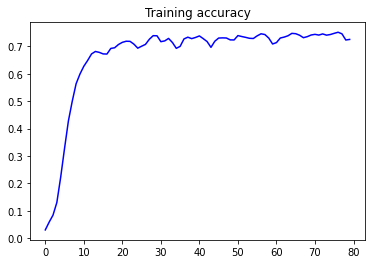

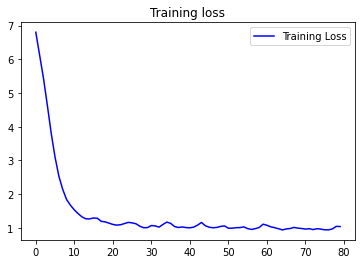

In [10]:
acc = history_shakespeare.history['accuracy']
loss = history_shakespeare.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [11]:
seed_text = "Oh my dear, I have"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer_shakespeare.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len_shakespeare-1, padding='pre')
	predicted = model_shakespeare.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer_shakespeare.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Oh my dear, I have confess'd that he doth bear her heart you ' have erred ' ' ' have ' might far mine eyes best was single best so bright ' ' ' were renew'd be call thee 'will' to boot and me 'will' ' ' have erred private ' had thee 'will' more


In [13]:
model_shakespeare.save('shakespeare_model.h5') 

In [14]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('shakespeare_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>